# Application: Generating Character Descriptions
 
Let's build a simple application that generates character descriptions using the concepts we've learned. 
We'll use Pydantic for our state schema to ensure data integrity.

In [1]:
from pydantic import BaseModel, field_validator, ValidationError
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import Literal
import random

In [2]:
# Define our state schema with Pydantic
class InputState(BaseModel):
    name: str = ""
    wants_details: bool = False 

class OutputState(BaseModel):
    description: str = ""

class CharacterState(BaseModel):
    name: str = ""
    age: int = 0
    species: Literal["Human", "Elf", "Dwarf"] = "Human"
    profession: str = ""
    trait: str = ""
    description: str = ""
    wants_details: bool = False

    @field_validator('species')
    @classmethod
    def validate_species(cls, value):
        if value not in ["Human", "Elf", "Dwarf"]:
            raise ValueError("Species must be either 'Human', 'Elf', or 'Dwarf'")
        return value

In [3]:
from langchain_ollama import ChatOllama
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message for the LLM
sys_msg = SystemMessage(content="You are a character description generator. When provided with the characteristics of a character (name, age, species, profession, and trait), you only output a short description of the character using the characteristics.") 

llm = ChatOllama(model='llama3.1', temperature=0.9, num_predict=128)

In [4]:
# --- State Graph Functions --- 
def get_age(state: CharacterState):
    age = random.randint(18, 100)
    print(f"Age: {age}")
    return {"age": age}

def get_species(state: CharacterState):
    species = random.choice(["Human", "Elf", "Dwarf"])
    print(f"Species: {species}")
    return {"species": species}

def get_profession(state: CharacterState):
    if state.species == "Human":
        profession = random.choice(["Warrior", "Mage", "Thief", "Priest", "Merchant", "Farmer"])
    elif state.species == "Elf":
        profession = random.choice(["Ranger", "Druid", "Bard", "Scholar", "Trader", "Hunter"])
    else:  # Dwarf
        profession = random.choice(["Miner", "Blacksmith", "Brewer", "Engineer", "Merchant", "Warrior"])
    print(f"Profession: {profession}")
    return {"profession": profession}

def get_trait(state: CharacterState):
    trait = random.choice(["brave", "wise", "stubborn", "clever", "loyal", "honest", "curious", "charming"])
    print(f"Trait: {trait}")
    return {"trait": trait}

def generate_description(state: CharacterState) -> OutputState:
    messages = [
        # sys_msg,
        HumanMessage(content=f"""
        Name: {state.name}
        Age: {state.age}
        Species: {state.species}
        Profession: {state.profession}
        Trait: {state.trait}
        Provide a {'detailed' if state.wants_details else 'short'} description.
        """)
    ]
    AI_response = llm.invoke(messages)
    response_content = AI_response.content.replace("\n", " ")
    print(response_content)
    return {"description": response_content}

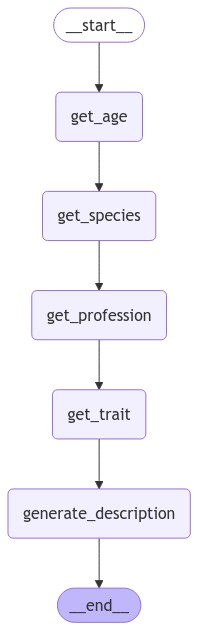

In [5]:
# --- Build the State Graph ---
builder = StateGraph(CharacterState, input=InputState, output=OutputState)
builder.add_node("get_age", get_age)
builder.add_node("get_species", get_species)
builder.add_node("get_profession", get_profession)
builder.add_node("get_trait", get_trait)
builder.add_node("generate_description", generate_description)

# Define the graph logic (edges)
builder.add_edge(START, "get_age")
builder.add_edge("get_age", "get_species")
builder.add_edge("get_species", "get_profession")
builder.add_edge("get_profession", "get_trait")
builder.add_edge("get_trait", "generate_description")
builder.add_edge("generate_description", END)

# Compile and run the graph
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke(CharacterState(
    name="Alice",
    wants_details=False
))

Age: 34
Species: Human
Profession: Merchant
Trait: wise
Alice is a seasoned merchant in her mid-30s, with a calm and composed demeanor that commands respect. Her years of experience have earned her the reputation as a shrewd and reliable businesswoman, known for her keen insight and wise decision-making skills. Despite her profession's reputation for cutthroat competition, Alice conducts herself with integrity and fairness, earning the trust and admiration of her peers and clients alike.


{'description': "Alice is a seasoned merchant in her mid-30s, with a calm and composed demeanor that commands respect. Her years of experience have earned her the reputation as a shrewd and reliable businesswoman, known for her keen insight and wise decision-making skills. Despite her profession's reputation for cutthroat competition, Alice conducts herself with integrity and fairness, earning the trust and admiration of her peers and clients alike."}